# **Test A/B**

## **Descripción del ejercicio**

En el presente proyecto se realizarà un anàlisis de dos grupos A y B, con el fin de determinar si los cambios realizados en el grupo B son significativamente mejores en cuanto a eficacia y generaciòn de ventas que el grupo A.

**Descripción técnica**

	• Nombre de la prueba: recommender_system_test
	• Grupos: А (control), B (nuevo embudo de pago)
	• Fecha de lanzamiento: 2020-12-07
	• Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
	• Fecha de finalización: 2021-01-01
	• Audiencia: 15% de los nuevos usuarios de la región de la UE
	• Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
	• Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento product_page), instancias de agregar artículos al carrito de compras (product_cart) y compras (purchase). En cada etapa del embudo product_page → product_cart → purchase, habrá al menos un 10% de aumento.
	• Número previsto de participantes de la prueba: 6 000


**Descripciòn de los datos**

	• ab_project_marketing_events_us.csv — el calendario de eventos de marketing para 2020
	• final_ab_new_users_upd_us.csv — todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020
	• final_ab_events_upd_us.csv — todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021
	• final_ab_participants_upd_us.csv — tabla con los datos de los participantes de la prueba
 
    Estructura ab_project__marketing_events_us.csv:
	• name — el nombre del evento de marketing
	• regions — regiones donde se llevará a cabo la campaña publicitaria
	• start_dt — fecha de inicio de la campaña
	• finish_dt — fecha de finalización de la campaña
 
    Estructura final_ab_new_users_upd_us.csv:
	• user_id
	• first_date — fecha de inscripción
	• region
	• device — dispositivo utilizado para la inscripción
 
    Estructura final_ab_events_upd_us.csv:
	• user_id
	• event_dt — fecha y hora del evento
	• event_name — nombre del tipo de evento
	• details — datos adicionales sobre el evento (por ejemplo, el pedido total en USD para los eventos purchase)
 
    Estructura final_ab_participants_upd_us.csv:
	• user_id
	• ab_test — nombre de la prueba
	• group — el grupo de prueba al que pertenecía el usuario


Descomposiciòn del proyecto:

1. Importar las librerias
2. Cargar y explorar los datasets
3. Analisis Exploratorio de los datos (EDA)
4. Evaluar los resultados de la prueba A/B:
5. Conclusiones

# 1. Importar librerias

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import seaborn as sns


# 2. Cargar y explorar los datasets

In [10]:
marketing_events_calendar = pd.read_csv('ab_project_marketing_events_us.csv')
customers = pd.read_csv('final_ab_new_users_upd_us.csv')
events = pd.read_csv('final_ab_events_upd_us.csv')
test_participants = pd.read_csv('final_ab_participants_upd_us.csv')

## Dataset: Calendario de eventos de marketing

In [11]:
marketing_events_calendar

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [12]:
def analisis_exploratorio_df(data):
    print(data.shape)
    print()
    print(data.info())
    print()
    print(data.describe())
    print()
    print('valores ausentes:',)
    print(data.isna().sum())
    print()
    print('filas duplicadas:', data.duplicated().sum())

In [13]:
analisis_exploratorio_df(marketing_events_calendar)

(14, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes
None

                            name regions    start_dt   finish_dt
count                         14      14          14          14
unique                        14       6          14          14
top     Christmas&New Year Promo    APAC  2020-12-25  2021-01-03
freq                           1       4           1           1

valores ausentes:
name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

filas duplicadas: 0


In [14]:
# Convertir columnas a tipo datetime
marketing_events_calendar['start_dt'] = pd.to_datetime(marketing_events_calendar['start_dt'])
marketing_events_calendar['finish_dt'] = pd.to_datetime(marketing_events_calendar['finish_dt'])

In [15]:
marketing_events_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 580.0+ bytes


**Conclusion dataset Marketing** En el dataset de (marketing_events_calendar), se evidencio que tiene 14 filas y 4 columnas, en las cuales no se encontraron valores ausentes ni duplicados. Sin embargo se modifico el formato de object a datetime en las columnas: start_dt y finish_dt, para poder realizar adecuadamente el análsis de los datos

## Dataset: Customers

In [16]:
customers

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
58698,1DB53B933257165D,2020-12-20,EU,Android
58699,538643EB4527ED03,2020-12-20,EU,Mac
58700,7ADEE837D5D8CBBD,2020-12-20,EU,PC
58701,1C7D23927835213F,2020-12-20,EU,iPhone


In [17]:
analisis_exploratorio_df(customers)

(58703, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB
None

                 user_id  first_date region   device
count              58703       58703  58703    58703
unique             58703          17      4        4
top     D72A72121175D8BE  2020-12-21     EU  Android
freq                   1        6077  43396    26159

valores ausentes:
user_id       0
first_date    0
region        0
device        0
dtype: int64

filas duplicadas: 0


In [18]:
# Convertir columnas a tipo datetime

customers['first_date'] = pd.to_datetime(customers['first_date'])

In [19]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  object        
 3   device      58703 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


**Conclusion dataset Customers** En el dataset de (customers), contiene 58.703 filas en 4 columnas, en las cuales no se encontraron valores ausentes ni duplicados. Sin embargo se modifico el formato de object a datetime en la columna: first_date, para poder realizar adecuadamente el análsis de los datos

## Dataset: events

In [20]:
events

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
423756,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [21]:
analisis_exploratorio_df(events)

(423761, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB
None

            details
count  60314.000000
mean      23.881219
std       72.228884
min        4.990000
25%        4.990000
50%        4.990000
75%        9.990000
max      499.990000

valores ausentes:
user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

filas duplicadas: 0


In [22]:
# Convertir columnas a tipo datetime

events['event_dt'] = pd.to_datetime(events['event_dt'])

In [23]:
# Revisar los valores ausentes de: details

missing_details = events[events['details'].isna()]
missing_details


,user_id,event_dt,event_name,details
60314,2E1BF1D4C37EA01F,2020-12-07 09:05:47,product_cart,NaN
60315,50734A22C0C63768,2020-12-07 13:24:03,product_cart,NaN
60316,5EB159DA9DC94DBA,2020-12-07 22:54:02,product_cart,NaN
60317,084A22B980BA8169,2020-12-07 15:25:55,product_cart,NaN
60318,0FC21E6F8FAA8DEC,2020-12-07 06:56:27,product_cart,NaN
...,...,...,...,...
423756,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


**Conclusion dataset events** : puede observar que solo hay valores en 'details' especificamente en el evento 'purchase' donde muestra el valor en USD para los eventos. Para los otros eventos: 'purchase', 'product_cart', 'product_page', 'login' no aparecen datos en details. Sin embargo, no se puede eliminar los datos con NaN ya que eliminaria los datos de las otros eventos que si vamos a necesitar posteriormente en el analisis, por ende se manejará los valores ausentes rellenandolos
con **'0'**

In [24]:
# Se modifica los NaN por un 0

events['details'] = events['details'].fillna(0)

In [25]:
events

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
423756,245E85F65C358E08,2020-12-30 19:35:55,login,0.00
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,0.00
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,0.00
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,0.00


In [26]:
# Se corrobora que ya no hayan valores ausentes:

events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  object        
 3   details     423761 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 12.9+ MB


In [27]:
# # Obtener valores únicos de la columna 'event_name'

unique_event_names = events['event_name'].unique()
print("Valores únicos en 'event_name':")
unique_event_names

Valores únicos en 'event_name':


array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

## Dataset: test_participants

In [28]:
test_participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
...,...,...,...
14520,1D302F8688B91781,B,interface_eu_test
14521,3DE51B726983B657,A,interface_eu_test
14522,F501F79D332BE86C,A,interface_eu_test
14523,63FBE257B05F2245,A,interface_eu_test


In [29]:
analisis_exploratorio_df(test_participants)

(14525, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB
None

                 user_id  group            ab_test
count              14525  14525              14525
unique             13638      2                  2
top     307C06C0E6F09B93      A  interface_eu_test
freq                   2   8214              10850

valores ausentes:
user_id    0
group      0
ab_test    0
dtype: int64

filas duplicadas: 0


**Conclusion dataset test_participants** Contiene 14.525 filas en 3 columnas, en las cuales no se encontraron valores ausentes ni duplicados. No hay necesidad de modificar los tipos de datos.

## 3. Analisis Exploratorio de los datos (EDA)

### Etapas del Embudo de ventas

Los eventos del embudo de ventas son: 'login' 'product_page' 'product_cart' 'purchase'. Se realizarà un anàlisis para cada etapa.

**Cantidad de usuarios en cada etapa**

In [30]:
# Filtrar eventos relevantes para el embudo

funnel_stages = events[events['event_name'].isin(['login', 'product_page', 'product_cart', 'purchase'])]
funnel_stages

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
423756,245E85F65C358E08,2020-12-30 19:35:55,login,0.00
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,0.00
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,0.00
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,0.00


In [31]:
# Número de usuarios únicos en cada etapa

stage_counts = funnel_stages.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)
print("Usuarios únicos en cada etapa del embudo:")
stage_counts

Usuarios únicos en cada etapa del embudo:


event_name
login           58696
product_page    38929
purchase        19568
product_cart    19284
Name: user_id, dtype: int64

**Tasas de conversión entre etapas**

Se calcularà la tasa de conversion de todas las etapas:

    login to product_page
    product_page to product_card
    product_card to purchase

In [32]:
# Usuarios únicos por etapa
login_users = stage_counts.get('login', 0)
product_page_users = stage_counts.get('product_page', 0)
product_cart_users = stage_counts.get('product_cart', 0)
purchase_users = stage_counts.get('purchase', 0)

In [33]:
# Tasas de conversión
conversion_login_to_page = product_page_users / login_users * 100 if login_users > 0 else 0

print(f"Tasa de conversión de login a product_page: {conversion_login_to_page:.2f}%")

Tasa de conversión de login a product_page: 66.32%


In [34]:
conversion_page_to_cart = product_cart_users / product_page_users * 100 if product_page_users > 0 else 0
print(f"Tasa de conversión de product_page a product_cart: {conversion_page_to_cart:.2f}%")

Tasa de conversión de product_page a product_cart: 49.54%


In [35]:
conversion_cart_to_purchase = purchase_users / product_cart_users * 100 if product_cart_users > 0 else 0
print(f"Tasa de conversión de product_cart a purchase: {conversion_cart_to_purchase:.2f}%")

Tasa de conversión de product_cart a purchase: 101.47%


**Visualizaciòn del Embudo**

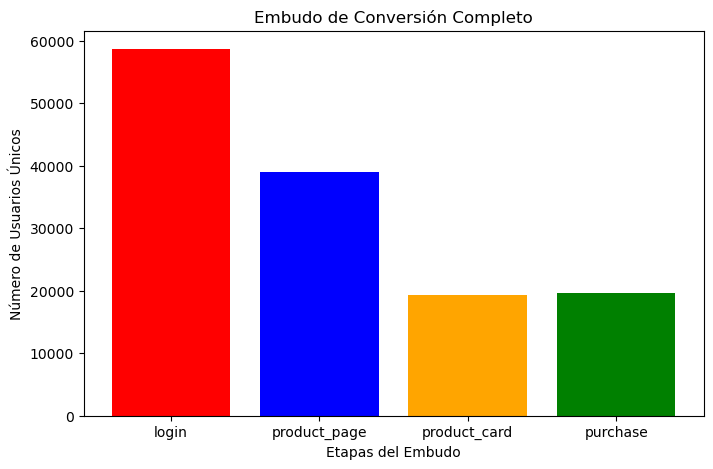

In [36]:
# Datos del embudo
stages = ['login', 'product_page', 'product_card', 'purchase']
values = [login_users, product_page_users, product_cart_users, purchase_users]

plt.figure(figsize=(8, 5))
plt.bar(stages, values, color=['red', 'blue', 'orange', 'green'])
plt.title('Embudo de Conversión Completo')
plt.xlabel('Etapas del Embudo')
plt.ylabel('Número de Usuarios Únicos')
plt.show()

En total se analizaron 136.477 usuarios de los cuales 58.696 llegaron a la etapa de Login, 38.929 llegaron a la pagina del producto, es decir un 66% de los usuarios pasaron esta etapa. 19.568 llegaron al carrito de compra, es decir un 49% de los clientes y de esos clientes, 19.284 llegaron a la compra, lo que equivale que porcentaje un 100% de los clientes llegan a la compra. Lo anterior es muy bueno para la compañia ya que lo que indica que es que tiene clientes fieles y un producto muy bueno, en el que los clientes no deben tomar tanto la decision de comprarlo o no, sino que ellos van directo a la pagina de compras y la efectuan. 

## Análisis por grupos A / B

In [37]:
# Combinar la tabla de eventos con los participantes del test A/B  para obtener el grupo de cada usuario:

events_with_groups = events.merge(test_participants[['user_id', 'group']], on='user_id', how='inner')
events_with_groups

,user_id,event_dt,event_name,details,group
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,B
1,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A
2,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99,A
3,354D653172FF2A2D,2020-12-07 15:45:11,purchase,4.99,A
4,7FCD34F47C13A9AC,2020-12-07 22:06:13,purchase,9.99,B
...,...,...,...,...,...
102833,75845C83258FBF73,2020-12-30 06:42:52,login,0.00,B
102834,4584E51B99DE51AE,2020-12-30 07:39:32,login,0.00,A
102835,9DF4F595A906A0BA,2020-12-30 18:28:55,login,0.00,B
102836,6181F3835EBE66BF,2020-12-30 12:00:00,login,0.00,A


In [38]:
# Filtrar los datos por cada grupo A
group_a = events_with_groups[events_with_groups['group'] == 'A']
group_a

,user_id,event_dt,event_name,details,group
1,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A
2,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99,A
3,354D653172FF2A2D,2020-12-07 15:45:11,purchase,4.99,A
5,0313C457F07C339E,2020-12-07 13:10:48,purchase,9.99,A
6,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,A
...,...,...,...,...,...
102831,DD4352CDCF8C3D57,2020-12-30 12:42:56,login,0.00,A
102832,5C31C0607EFC3C98,2020-12-30 01:56:08,login,0.00,A
102834,4584E51B99DE51AE,2020-12-30 07:39:32,login,0.00,A
102836,6181F3835EBE66BF,2020-12-30 12:00:00,login,0.00,A


In [39]:
# Filtrar los datos por cada grupo B

group_b = events_with_groups[events_with_groups['group'] == 'B']
group_b 

,user_id,event_dt,event_name,details,group
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,B
4,7FCD34F47C13A9AC,2020-12-07 22:06:13,purchase,9.99,B
7,C39E95E709714A06,2020-12-07 09:07:20,purchase,4.99,B
8,78B3AFBB700310CC,2020-12-07 23:44:09,purchase,4.99,B
9,80CEAF824A1F3E28,2020-12-07 15:54:06,purchase,499.99,B
...,...,...,...,...,...
102828,8CE3B6FD918462B4,2020-12-29 17:55:44,login,0.00,B
102829,2C29721DDDA76B2A,2020-12-29 05:58:20,login,0.00,B
102830,DD4352CDCF8C3D57,2020-12-30 12:42:56,login,0.00,B
102833,75845C83258FBF73,2020-12-30 06:42:52,login,0.00,B


## **Cantidad de usuarios en cada etapa Por Grupo A/B**

**Grupo A**

In [40]:
# Calcular usuarios únicos en cada etapa del embudo para el grupo A

group_a_login = group_a[group_a['event_name'] == 'login']['user_id'].nunique()
group_a_product_page = group_a[group_a['event_name'] == 'product_page']['user_id'].nunique()
group_a_product_cart = group_a[group_a['event_name'] == 'product_cart']['user_id'].nunique()
group_a_purchase = group_a[group_a['event_name'] == 'purchase']['user_id'].nunique()

print("Grupo A:")
print(f"Login: {group_a_login}, Product Page: {group_a_product_page}, Product Cart: {group_a_product_cart}, Purchase: {group_a_purchase}")

Grupo A:
Login: 7873, Product Page: 5208, Product Cart: 2483, Purchase: 2682


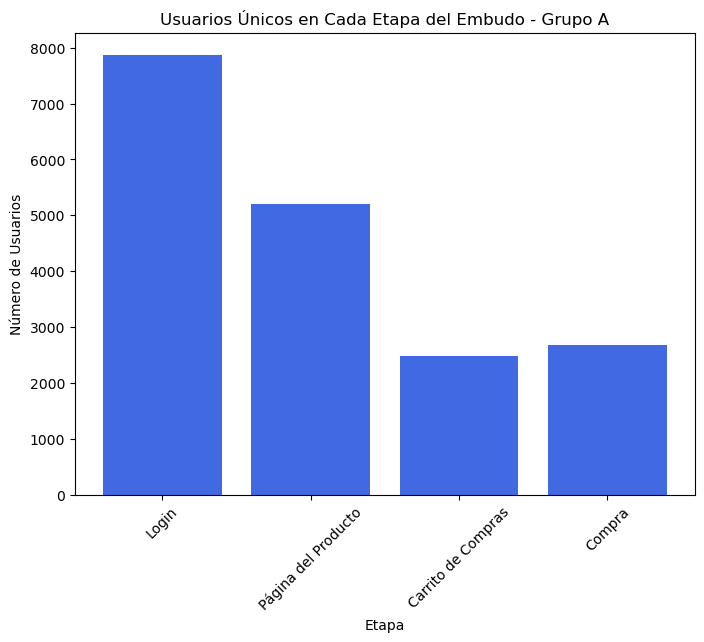

In [41]:
# Datos de usuarios únicos en cada etapa
etapas = ['Login', 'Página del Producto', 'Carrito de Compras', 'Compra']
usuarios = [group_a_login, group_a_product_page, group_a_product_cart, group_a_purchase]

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(etapas, usuarios, color='royalblue')

# Agregar títulos y etiquetas
plt.title('Usuarios Únicos en Cada Etapa del Embudo - Grupo A')
plt.xlabel('Etapa')
plt.ylabel('Número de Usuarios')
plt.xticks(rotation=45)
plt.show()

**Tasa de Conversion del Grupo A**

In [42]:

# Calcular tasas de conversión para el grupo A
group_a_login_to_page = (group_a_product_page / group_a_login) * 100
group_a_page_to_cart = (group_a_product_cart / group_a_product_page) * 100
group_a_cart_to_purchase = (group_a_purchase / group_a_product_cart) * 100

# Imprimir los resultados
print("Tasas de conversión Grupo A:")
print(f"De login a product_page: {group_a_login_to_page:.2f}%")
print(f"De product_page a product_cart: {group_a_page_to_cart:.2f}%")
print(f"De product_cart a purchase: {group_a_cart_to_purchase:.2f}%")

Tasas de conversión Grupo A:
De login a product_page: 66.15%
De product_page a product_cart: 47.68%
De product_cart a purchase: 108.01%


**Conclusion del Grupo A:**  

* De login a product_page: 
Se puede identificar que de los 58.705 clientes que participaron en el Grupo A, 7873 llegaron a la pagina de Login, 5.208 llegaron a la pagina del producto, lo que equivale que el 66.15% de los usuarios mostraron interes al explorar el producto. Es importante analizar por qué el 33.85% restante no avanzó a la página del producto. Tal vez la interfaz después del inicio de sesión no sea intuitiva o no presente incentivos claros para continuar.

* De product_page a product_cart:
De los 5208 usuarios que visitaron la página del producto, el 47.68% (2.483) agregaron un producto al carrito. Los demas clientes tal vez no agregaron el producto al carrito por el precio, por falta de interes, falta información o problemas de navegacion. 

* De product_cart a purchase:
Este resultado es atipico, ya que indica que el número de compras (2.682) supera al número de usuarios que agregaron productos al carrito (2.483).Puede ser que algunos usuarios hayan comprado directamente sin pasar por la etapa del carrito o que compraran múltiples veces.

**Grupo B**

In [43]:
# Calcular usuarios únicos en cada etapa del embudo para el grupo B
group_b_login = group_b[group_b['event_name'] == 'login']['user_id'].nunique()
group_b_product_page = group_b[group_b['event_name'] == 'product_page']['user_id'].nunique()
group_b_product_cart = group_b[group_b['event_name'] == 'product_cart']['user_id'].nunique()
group_b_purchase = group_b[group_b['event_name'] == 'purchase']['user_id'].nunique()

print("\nGrupo B:")
print(f"Login: {group_b_login}, Product Page: {group_b_product_page}, Product Cart: {group_b_product_cart}, Purchase: {group_b_purchase}")


Grupo B:
Login: 6204, Product Page: 3986, Product Cart: 2037, Purchase: 2008


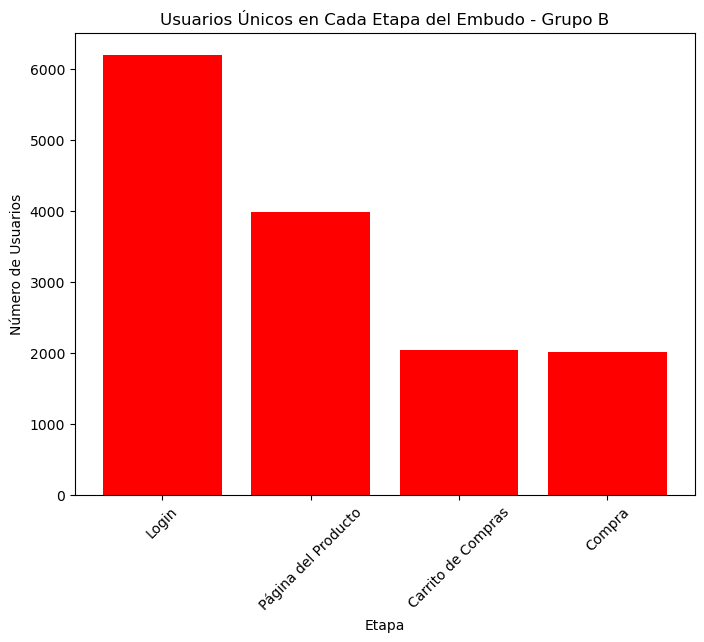

In [44]:
# Datos de usuarios únicos en cada etapa
etapas = ['Login', 'Página del Producto', 'Carrito de Compras', 'Compra']
usuarios = [group_b_login, group_b_product_page, group_b_product_cart, group_b_purchase]

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(etapas, usuarios, color='red')

# Agregar títulos y etiquetas
plt.title('Usuarios Únicos en Cada Etapa del Embudo - Grupo B')
plt.xlabel('Etapa')
plt.ylabel('Número de Usuarios')
plt.xticks(rotation=45)
plt.show()

**Tasa de Conversion del Grupo B**

In [45]:
# Calcular tasas de conversión para el grupo B
group_b_login_to_page = (group_b_product_page / group_b_login) * 100
group_b_page_to_cart = (group_b_product_cart / group_b_product_page) * 100
group_b_cart_to_purchase = (group_b_purchase / group_b_product_cart) * 100

# Imprimir los resultados
print("Tasas de conversión Grupo B:")
print(f"De login a product_page: {group_b_login_to_page:.2f}%")
print(f"De product_page a product_cart: {group_b_page_to_cart:.2f}%")
print(f"De product_cart a purchase: {group_b_cart_to_purchase:.2f}%")

Tasas de conversión Grupo B:
De login a product_page: 64.25%
De product_page a product_cart: 51.10%
De product_cart a purchase: 98.58%


**Conclusion del Grupo B:**  

* **De login a product_page:** 
Se puede identificar que de los 44.103  clientes que participaron en el Grupo B, solo 6.204 usuarios llegaron a la pagina de Login, 3.986 avanzaron a la pagina del producto, lo que equivale que el 64.25% de los usuarios mostraron interes al explorar el producto. Esta tasa es similar a la del grupo A (66.15%), lo que sugiere que el nuevo embudo no afectó significativamente el interés inicial en explorar los productos.

* **De product_page a product_cart:**
Aquí se observa que el 51.10% de los usuarios que vieron la página del producto (3.986) agregaron artículos al carrito (2.037). Esta tasa es más alta que la del grupo A, lo que podría indicar que el nuevo embudo de pagos motiva más a los usuarios a agregar productos al carrito.

* **De product_cart a purchase:**
Esta tasa muestra que casi todos los usuarios que agregaron productos al carrito (2.037) completaron la compra (2.008), lo que equivale a un 98.58%. En este grupo no se observo lo que paso en el grupo B, es decir ningun usuario se salto la etapa del carrito de compra.

El grupo B, que utiliza el nuevo embudo de pagos, muestra un desempeño muy positivo: Mayor conversión en la etapa de agregar al carrito (51.10% vs. 47.68%), sugiriendo que el nuevo proceso facilita o motiva más esta acción. Ademas, Menor abandono en la etapa final (98.58% vs. 108.01%), lo que podría reflejar una experiencia de pago más rápida y sin fricciones.

## ¿El número de eventos por usuario está distribuido equitativamente entre las muestras?

In [46]:
# Calcular el número de eventos por usuario para cada grupo

events_per_user_a = group_a.groupby('user_id')['event_name'].count()
events_per_user_b = group_b.groupby('user_id')['event_name'].count()

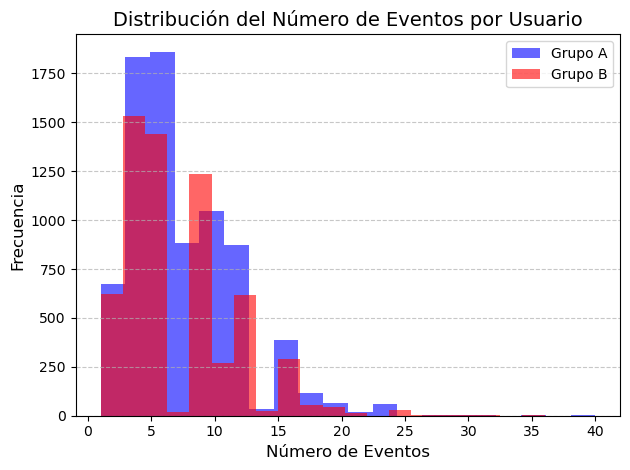

In [47]:
# Visualizar las distribuciones con histogramas
# Histograma para el grupo A
plt.hist(events_per_user_a, bins=20, alpha=0.6, color='blue', label='Grupo A')

# Histograma para el grupo B
plt.hist(events_per_user_b, bins=20, alpha=0.6, color='red', label='Grupo B')

# Personalizar el gráfico
plt.title('Distribución del Número de Eventos por Usuario', fontsize=14)
plt.xlabel('Número de Eventos', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


Ambos grupos tienen distribuciones con forma similar, indicando que la mayoría de los usuarios realizan un número bajo de eventos (entre 1 y 10 eventos).

* Grupo A (azul): Tiene una mayor frecuencia de usuarios con 5-10 eventos, mostrando picos más altos en comparación con el grupo B.
* Grupo B (naranja):Aunque sigue una distribución similar, su frecuencia es ligeramente menor en los niveles más altos de eventos (más de 10 eventos).
Esto podría implicar que el nuevo embudo fomenta interacciones más rápidas y directas, reduciendo la necesidad de realizar múltiples eventos.


En conclusion, la menor cantidad de eventos en el grupo B podría estar relacionada con un proceso más optimizado y eficiente, como el nuevo embudo de pagos, que requiere menos pasos para completar las acciones.

In [48]:
# Resumen estadístico de los eventos por usuario para cada grupo

summary_a = events_per_user_a.describe()
summary_b = events_per_user_b.describe()

print("Resumen estadístico para el grupo A:")
print(summary_a)
print("\nResumen estadístico para el grupo B:")
print(summary_b)

Resumen estadístico para el grupo A:
count    7874.000000
mean        7.455550
std         4.475159
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        40.000000
Name: event_name, dtype: float64

Resumen estadístico para el grupo B:
count    6205.000000
mean        7.112490
std         4.246201
min         1.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        36.000000
Name: event_name, dtype: float64


Conclusion del resumen estadistico por Grupo:

* Grupo A: Los usuarios realizan minimo 1 evento y maximo 40 eventos. En promedio, los usuarios realizan alrededor de 7 eventos.25%: 4 eventos (el 25% de los usuarios realizó 4 eventos o menos).El 50% (mediana): 6 eventos (la mitad de los usuarios realizó 6 eventos o menos). En el 75%: 9 eventos (el 75% de los usuarios realizó 9 eventos o menos).

* Grupo B:Los usuarios de este grupo, realizaron menos eventos respecto al grupo A, realizaron minimo 1 evento y maximo 36. Los cuartiles son iguales que el grupo A.

En conclusión: Teniendo en cuenta que el Grupo B, tiene menos eventos realizados por los usuarios, esto indica que el nuevo embudo de pagos reduce la cantidad de interacciones necesarias para completar el proceso. 

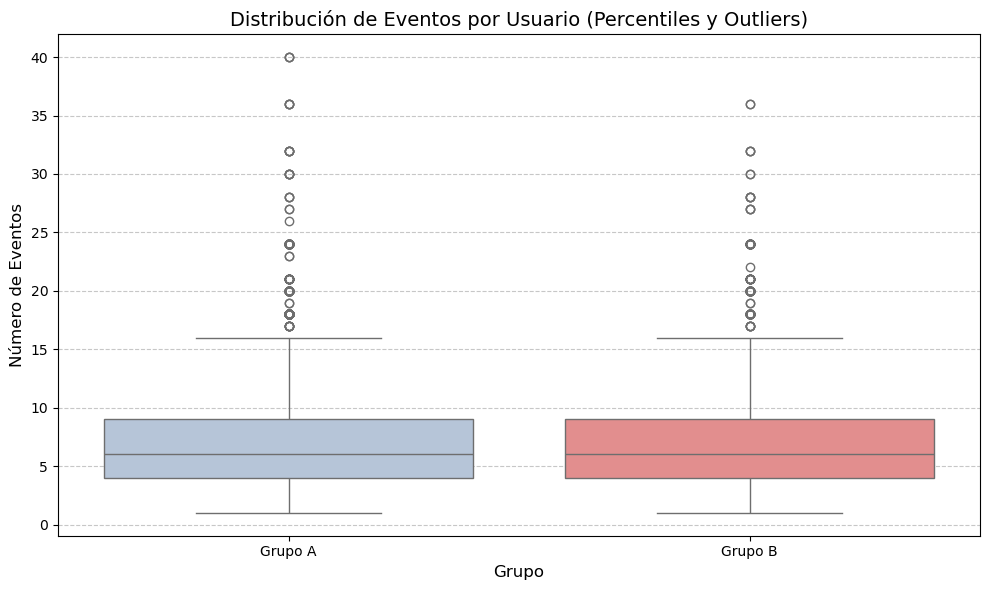

In [49]:
# Graficar los percentiles:
# Crear el conjunto de datos
data = {'Grupo A': events_per_user_a, 'Grupo B': events_per_user_b}

# Crear un DataFrame para graficar
import pandas as pd
df = pd.DataFrame(data)

# Crear el boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, palette=["lightsteelblue", "lightcoral"])

# Personalizar el gráfico
plt.title('Distribución de Eventos por Usuario (Percentiles y Outliers)', fontsize=14)
plt.ylabel('Número de Eventos', fontsize=12)
plt.xlabel('Grupo', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

Esta grafica muestra la distribucion del número de eventos por usuario en los grupos A y B. Ademas de los outliers que son los usuarios con un número de eventos mayor que el resto , los cuales se pueden evidencial en mayor medida en el grupo A. En el grupo B, indica un comportamiento mas consistente y controlado con menos cantidad de eventos.

La prueba de Mann-Whitney U se utiliza para comparar si dos muestras independientes provienen de la misma distribución. En este caso, se aplicó para analizar si las distribuciones del número de eventos por usuario en los grupos A y B son estadísticamente diferentes. Con el resultado de la prueba hay evidencia estadísticamente significativa para afirmar que las distribuciones del número de eventos por usuario en los grupos A y B Si son diferentes.
Esto sugiere que el nuevo embudo de pagos (Grupo B) genera un patrón de comportamiento diferente al del embudo original (Grupo A).

## ¿Hay usuarios que están presentes en ambas muestras?

In [50]:
# Identificar usuarios en cada grupo
users_a = set(group_a['user_id'])
users_b = set(group_b['user_id'])

In [51]:
# Encontrar intersección entre ambos grupos
overlap_users = users_a.intersection(users_b)

# Número de usuarios en ambas muestras
print(f"Número de usuarios presentes en ambas muestras: {len(overlap_users)}")

Número de usuarios presentes en ambas muestras: 441


## ¿Cómo se distribuye el número de eventos entre los días?


In [52]:
# Extraer la fecha sin la hora
events['event_date'] = events['event_dt'].dt.date

# Agrupar por fecha y contar eventos
events_per_day = events.groupby('event_date').size().reset_index(name='event_count')

# Ordenar por fecha (opcional)
events_per_day = events_per_day.sort_values(by='event_date')

# Mostrar la distribución
print(events_per_day)

    event_date  event_count
0   2020-12-07        11385
1   2020-12-08        12547
2   2020-12-09        12122
3   2020-12-10        14077
4   2020-12-11        13864
5   2020-12-12        17634
6   2020-12-13        20985
7   2020-12-14        26184
8   2020-12-15        23469
9   2020-12-16        20909
10  2020-12-17        21751
11  2020-12-18        22871
12  2020-12-19        24273
13  2020-12-20        26425
14  2020-12-21        32559
15  2020-12-22        29472
16  2020-12-23        26108
17  2020-12-24        19399
18  2020-12-26        14058
19  2020-12-27        12420
20  2020-12-28        11014
21  2020-12-29        10146
22  2020-12-30           89


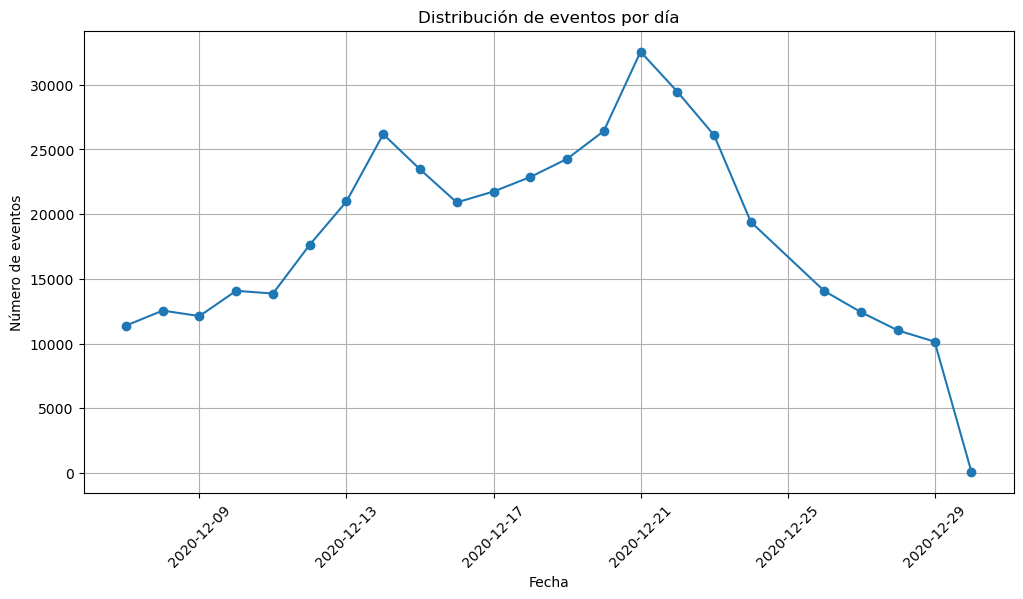

In [61]:
# Grafica de la distribución de los eventos entre los días

plt.figure(figsize=(12, 6))
plt.plot(events_per_day['event_date'], events_per_day['event_count'], marker='o')
plt.title('Distribución de eventos por día')
plt.xlabel('Fecha')
plt.ylabel('Número de eventos')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

En la grafica se puede observar que la fecha de lanzamiento de la prueba fue el 7 de diciembre y hay dos picos importantes durante la realización de la prueba, comenzando el 14 de diciembre hasta el 26 de diciembre, siendo el 21 de diciembre el dia en el que se evidenciaron la mayor cantidad de eventos.

## ¿Hay alguna peculiaridad en los datos que hay que tener en cuenta antes de iniciar la prueba A/B?

Con el analisis de los datos, es importante darse cuenta que en el proyecto indican que se dejaron de aceptar usuarios el 21 de diciembre, pero se observa eventos hasta el 29 de diciembre, lo cual es importante tenerlo presente en las conclusiones finales 

## 4.  Evaluar los resultados de la prueba A/B:

Tal y como se mencionò anteriormente, se puede concluir en el analisis de los resultados de la prueba A/B: que:

* El grupo A: más usuarios realizaron compras de los que añadieron productos al carrito (posiblemente porque algunos usuarios compraron más de un artículo), ya que se saltaron la etapa de la pagina del carrito. Por eso se observa que la tasa de compra es mayor que la del grupo B.
* El grupo B: Mejor desempeño de conversion para que las personas añadan productos al carrito, respecto al grupo A.

Sin embargo se realizarà la prueba Z, para verificar si las diferencias son significatifvas. 

## Prueba Z


**Prueba Z de las conversion de Product_page a product_cart**

In [77]:
# Datos para product_cart
success_a_cart = conversion.loc['A', 'product_cart']  # Éxitos en grupo A (product_cart)
success_b_cart = conversion.loc['B', 'product_cart']  # Éxitos en grupo B (product_cart)

n_a = len(test_participants[test_participants['group'] == 'A'])  # Tamaño del grupo A
n_b = len(test_participants[test_participants['group'] == 'B'])  # Tamaño del grupo B

# Proporciones
p1_cart = success_a_cart / n_a
p2_cart = success_b_cart / n_b

# Proporción combinada
p_combined_cart = (success_a_cart + success_b_cart) / (n_a + n_b)

# Estadístico Z
z_score_cart = (p1_cart - p2_cart) / np.sqrt(p_combined_cart * (1 - p_combined_cart) * (1/n_a + 1/n_b))

# Valor p (dos colas)
p_value_cart = 2 * (1 - norm.cdf(abs(z_score_cart)))

print(f"Product Cart - Estadístico Z: {z_score_cart}")
print(f"Product Cart - Valor p: {p_value_cart}")

Product Cart - Estadístico Z: -2.6427600309462336
Product Cart - Valor p: 0.008223329415643077


**En conclusion**: Si Existe una diferencia significativa entre los grupos A y B en la tasa de conversión de la página del producto (product_page) a agregar al carrito (product_cart).
El resultado sugiere que el grupo B (nuevo embudo) tiene una mayor conversión en esta etapa del embudo en comparación con el grupo A (control).

**Prueba Z de las conversion de  product_cart a purchase**

In [81]:
# Datos para purchase
success_a_purchase = conversion.loc['A', 'purchase']  # Éxitos en grupo A (purchase)
success_b_purchase = conversion.loc['B', 'purchase']  # Éxitos en grupo B (purchase)

# Proporciones
p1_purchase = success_a_purchase / n_a
p2_purchase = success_b_purchase / n_b

# Proporción combinada
p_combined_purchase = (success_a_purchase + success_b_purchase) / (n_a + n_b)

# Estadístico Z
z_score_purchase = (p1_purchase - p2_purchase) / np.sqrt(p_combined_purchase * (1 - p_combined_purchase) * (1/n_a + 1/n_b))

# Valor p (dos colas)
p_value_purchase = 2 * (1 - norm.cdf(abs(z_score_purchase)))

print(f"Purchase - Estadístico Z: {z_score_purchase}")
print(f"Purchase - Valor p: {p_value_purchase}")

Purchase - Estadístico Z: 1.0656968180147015
Purchase - Valor p: 0.28656071652916815


**En conclusiòn**: No hay evidencia suficiente para afirmar que el grupo B (nuevo embudo) tenga un desempeño significativamente diferente al grupo A (control) en esta etapa del embudo. En otras palabras, el nuevo embudo no mejoró significativamente la conversión de agregar al carrito (product_cart) a realizar una compra (purchase).

## 5.  Conclusiones

En conclusiòn final se puede determinar que el Grupo B, tuvo una mejora significativa en la etapa de agregar productos al carrito (product_cart). Sin embargo, esta mejora no se tradujo en un incremento significativo en las compras (purchase). Lo anterior no es beneficioso para la compañia, ya que èsta lo que busca es incrementar sus ventas. Se recomienda revisar de nuevo el embudo y si es posible optimizarlo para que el cliente pueda comprar mucho mas rapido, tal vez tambien ofrecer mas mètodos de pago e incluir una opcion en la que se le recuerde al cliente por medio de un correo o mensaje que tiene productos en el carrito y que puede completar la compra.